## Overview

This notebook contains the replay-only approach for training coarse-grained and fine-grained datasets in a continual learning classification setting.

In [1]:
# seeds for reproducibility
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torch
import torch.backends.cudnn as cudnn
import random
import numpy as np

# seeds
seed = 88
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.deterministic = True
cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Data Loading and Transforms

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset

# remove copyright banner
class RemoveCopyrightBanner(object):
    def __call__(self, img):
        width, height = img.size
        return img.crop((0, 0, width, height - 20))

transform = transforms.Compose([
    RemoveCopyrightBanner(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# granularity = 'variant'

# # Create the FGVC Aircraft dataset instance
# train_dataset = FGVCAircraft(
#     root='./data',
#     split='trainval',              # Options: 'train', 'val', 'trainval', 'test'
#     annotation_level=granularity,    # Options: 'variant', 'family', 'manufacturer'
#     transform=transform,
#     download=True
# )

# val_dataset = FGVCAircraft(
#     root='./data',
#     split='val',
#     annotation_level='variant',
#     transform=transform,
#     download=True
# )

# test_dataset = FGVCAircraft(
#     root='./data',
#     split='test',
#     annotation_level=granularity,
#     transform=transform,
#     download=True
# )

data_root = './data'

train_dataset = datasets.DTD(
    root=data_root,
    split='train',
    download=True,
    transform=transform
)

val_dataset = datasets.DTD(
    root=data_root,
    split='val',
    download=True,
    transform=transform
)
test_dataset = datasets.DTD(
    root=data_root,
    split='test',
    download=True,
    transform=transform
)

trainval_dataset = ConcatDataset([train_dataset, val_dataset])
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [0.8, 0.2], generator=g)

100%|██████████| 625M/625M [00:03<00:00, 201MB/s]


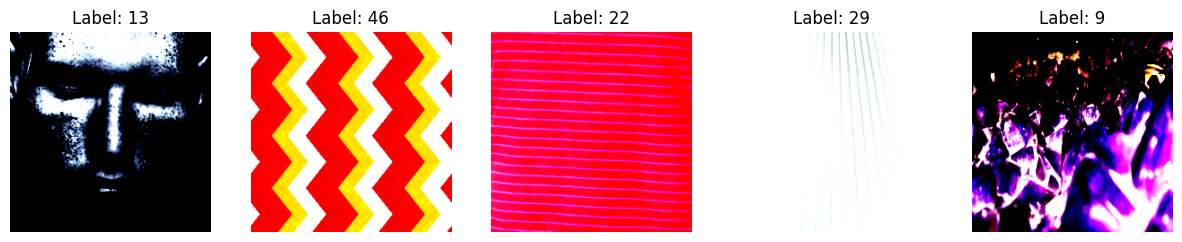

In [3]:
# function to show images
def show_images(train_dataset, num_images=5):
  #shuffle the dataset
  train_dataset = torch.utils.data.Subset(train_dataset, torch.randperm(len(train_dataset)))
  fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
  for i in range(num_images):
      image, label = train_dataset[i]
      image = image.permute(1, 2, 0)  # convert from CxHxW to HxWxC
      axes[i].imshow(image)
      axes[i].set_title(f'Label: {label}')
      axes[i].axis('off')
  plt.show()

show_images(train_dataset, num_images=5)

## Create the Dataset
In a continual learning setting, each task contains a new set of classes to train the model on. The validation and test datasets should be cumulative (to evalute the performance of the model on all classes seen by the model so far).

In [4]:
from collections import defaultdict
import torch
from tqdm import tqdm

def group_task_indices(dataset, cumulative=False, max_per_class=1000, classes_per_task=10):
    """
    Task 0: 0-9, Task 1: 10-19, ..., Task 9: 90-99 for train
    Output a dictionary where keys are task indices and values are lists of image indices.
    For example, task_dict[0] will contain indices of images with labels 0-9.
    """
    per_class_counts = defaultdict(int)
    task_dict = defaultdict(list)
    for idx, (_, label) in tqdm(enumerate(dataset), total=len(dataset)):
        # for test and val, should have cumulative indices (all classes seen so far)
        if per_class_counts[label] >= max_per_class:
          continue
        per_class_counts[label] += 1
        if cumulative:
          for i in range((label // classes_per_task), classes_per_task):
            task_dict[i].append(idx)
        else:
          task_dict[label // classes_per_task].append(idx)
    return task_dict

train_task_idxs = group_task_indices(train_dataset, cumulative=False, max_per_class=60)
val_task_idxs = group_task_indices(val_dataset, cumulative=True)
test_task_idxs = group_task_indices(test_dataset, cumulative=True)

100%|██████████| 1880/1880 [00:09<00:00, 202.66it/s]


## Training Functions

In [5]:
def val_net(net_to_val, val_loader):
    net_to_val.eval()
    loss = 0

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for img, label in tqdm(val_loader, desc="Validating"):

            # Get the input images and their corresponding labels
            img, label = img.cuda(), label.cuda()

            # Forward pass: Get predictions from the model
            outputs = net_to_val(img)
            loss += criterion(outputs, label)

        return loss / len(val_loader)

def train_net(max_epochs, freeze_epochs, patience, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    net_to_train.cuda()

    initial_freeze = (task == 0) # only freeze backbone for task 0

    for name, param in net_to_train.named_parameters():
        # do not train non-fc layers
        if initial_freeze and 'fc' not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    optimizer = opt
    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"Starting training for Task {task}. Trainable parameters:")
    for name, param in net_to_train.named_parameters():
        if param.requires_grad:
             print(f"  - {name}")


    for epoch in range(max_epochs):
        net_to_train.train()
        running_loss = 0.0

        # Unfreeze logic (if desired for staged training within a task)
        if epoch == freeze_epochs and task > 0: # Only unfreeze/adjust LR if NOT task 0 and freeze_epochs > 0
            print(f"Unfreezing backbone at epoch {epoch} for task {task}")
            for param in net_to_train.parameters():
                param.requires_grad = True
            # Adjust LR for the existing optimizer
            current_lr = optimizer.param_groups[0]['lr']
            new_lr = 1e-4
            if current_lr != new_lr:
                 print(f"Setting LR to {new_lr}")
                 for g in optimizer.param_groups:
                     g['lr'] = new_lr


        for imgs, labels in tqdm(train_loader, unit='batch', desc=f"Task {task} Epoch {epoch+1}"):
            imgs, labels = imgs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = net_to_train(imgs)
            loss = criterion(outputs, labels) # Loss calculated on combined batch
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # validation loss computation
        current_val_loss = val_net(net_to_train, val_loader)
        val_losses.append(current_val_loss)

        print(f"Task {task}, Epoch {epoch + 1}, Train Loss: {avg_loss:.4f}, Val Loss: {current_val_loss:.4f}")

        # logging
        if save_file:
             with open(save_file, 'a') as f:
                  f.write(f"{task},{epoch + 1},{avg_loss},{current_val_loss}\n")

        # early stopping based on validation loss
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            epochs_no_improve = 0
            if save_path:
               torch.save(net_to_train.state_dict(), os.path.join(save_path, f"model_task{task}_best.pth"))
               print(f"  New best validation loss: {best_val_loss:.4f}. Saved best model.")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1} for task {task}. Best Val Loss: {best_val_loss:.4f}")
            if save_path and os.path.exists(os.path.join(save_path, f"model_task{task}_best.pth")):
               print("Loading best model weights before exiting.")
               net_to_train.load_state_dict(torch.load(os.path.join(save_path, f"model_task{task}_best.pth")))
            break

    print(f"Finished training task {task}")
    return train_losses, val_losses

In [6]:
import torch.nn as nn
def modify_resnet_head(model, num_classes):
  """
  Modify the last fully connected layer of the ResNet model to match the number of classes.
  """

  old_fc = model.fc
  old_num_classes = old_fc.out_features
  num_ftrs = old_fc.in_features

  # Create the new head
  new_fc = nn.Linear(num_ftrs, num_classes).cuda()

  # Copy weights and biases from the old head
  if old_num_classes < num_classes:
    new_fc.weight.data[:old_num_classes, :] = old_fc.weight.data.clone().cuda()
    new_fc.bias.data[:old_num_classes] = old_fc.bias.data.clone().cuda()

  model.fc = new_fc
  return model

In [7]:
import torch

def get_test_accuracy(model, test_loader, num_classes):
    model.eval()
    correct_preds = 0
    total = 0
    correct_per_class = [0] * num_classes
    total_per_class = [0] * num_classes

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing", total=len(test_loader)):
            imgs, labels = imgs.cuda(), labels.cuda()
            output = model(imgs)
            preds = output.argmax(dim=1)

            correct_preds += (preds == labels).sum().item()
            total += labels.size(0)

            # Per-class stats
            for c in range(num_classes):
                correct_per_class[c] += ((preds == c) & (labels == c)).sum().item()
                total_per_class[c] += (labels == c).sum().item()

    overall_acc = correct_preds / total
    per_class_acc = [correct_per_class[c] / total_per_class[c] if total_per_class[c] > 0 else 0.0
                     for c in range(num_classes)]
    return overall_acc, per_class_acc


## Replay Classes and Helpers

In [9]:
from torch.utils.data import Dataset
def update_memory_buffer(buffer, max_size, new_samples):
    """Adds new samples to the buffer and trims it if it exceeds max_size."""
    buffer.extend(new_samples)
    # If buffer exceeds max size, remove samples randomly
    overflow = len(buffer) - max_size
    if overflow > 0:
        indices_to_remove = random.sample(range(len(buffer)), overflow)
        for index in sorted(indices_to_remove, reverse=True):
            del buffer[index]
    print(f"Memory buffer size: {len(buffer)} / {max_size}")

class MemoryDataset(Dataset):
    """Dataset class for the memory buffer."""
    def __init__(self, buffer_list):
        self.buffer = buffer_list

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        # buffer contains (image_tensor, label)
        return self.buffer[idx]

## Training Loop

In [10]:
import random
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import models
import torch.optim as optim


# model initialization
model = models.resnet18(pretrained=True)

# memory buffer initialization
memory_buffer = [] # store (image_tensor, label) tuples
memory_size = 1000 # max size of memory buffer
samples_per_task_in_memory = 20 # number of samples to keep in memory for each task

save_dir = 'replay-coarse-grained' # Changed directory name

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
open(os.path.join(save_dir, 'train_val_losses.txt'), 'w').close()
open(os.path.join(save_dir, 'accuracies.txt'), 'w').write("Task,Overall Accuracy,Per-Class Accuracy\n")


for task in range(5):
    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    # get current task data
    current_task_train_subset = Subset(train_dataset, train_task_idxs[task])

    # combine with memory buffer if task > 0
    if task > 0 and len(memory_buffer) > 0:
        replay_dataset = MemoryDataset(memory_buffer)
        combined_train_dataset = ConcatDataset([current_task_train_subset, replay_dataset])
        print(f"Task {task}: Training with {len(current_task_train_subset)} current samples and {len(replay_dataset)} replay samples.")
    else:
        # task 0 or empty buffer: train only on current task data
        combined_train_dataset = current_task_train_subset
        print(f"Task {task}: Training only with {len(current_task_train_subset)} current samples.")

    # dataloader for current task
    train_loader_combined = DataLoader(
        combined_train_dataset,
        batch_size=128,
        shuffle=True,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # validation and test loaders for the current task
    val_loader = torch.utils.data.DataLoader(
        Subset(val_dataset, val_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )
    test_loader = torch.utils.data.DataLoader(
        Subset(test_dataset, test_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # optimizer initialization
    if task == 0:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0015)
    else:
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # Lower LR for full network


    # train the model
    train_losses, val_losses = train_net(
        max_epochs=15,
        freeze_epochs=5,
        patience=5,
        net_to_train=model,
        opt=optimizer,
        train_loader=train_loader_combined,
        val_loader=val_loader,
        task=task,
        save_file=os.path.join(save_dir, 'train_val_losses.txt')
    )

    # select samples from current task for memory buffer
    num_to_sample = min(samples_per_task_in_memory, len(current_task_train_subset))
    if num_to_sample > 0:
        indices_to_sample = random.sample(range(len(current_task_train_subset)), num_to_sample)
        new_memory_samples = []
        print(f"Sampling {num_to_sample} examples from task {task} for memory buffer...")
        for idx in indices_to_sample:
            img_tensor, label = current_task_train_subset[idx]
            new_memory_samples.append((img_tensor, label)) # append as tuple

        # add to buffer
        update_memory_buffer(memory_buffer, memory_size, new_memory_samples)
    else:
        print(f"Not enough samples in task {task} subset to add to memory.")


    # evaluate and save
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader, (task+1) * 10)
    print(f"Overall accuracy for task {task} (on classes 0-{(task+1)*10 - 1}): {overall_acc:.4f}")

    with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
        f.write(f"{task},{overall_acc:.4f},{per_class_acc}\n")

    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task}.pth"))
    print(f"Model for task {task} saved as model_task_{task}.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


Training on task 0...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Task 0: Training only with 599 current samples.
Starting training for Task 0. Trainable parameters:
  - fc.weight
  - fc.bias


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Task 0, Epoch 1, Train Loss: 2.4340, Val Loss: 2.0589


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Task 0, Epoch 2, Train Loss: 1.8791, Val Loss: 1.6010


Task 0 Epoch 3:   0%|          | 0/5 [00:02<?, ?batch/s]


KeyboardInterrupt: 